## Reconstruct single-channel BrainWeb simulation and compute MSE

This notebook applies the forward model of UniRes (x = Ay + n) to an 'ideal' MR image from the [BrainWeb simulator](https://brainweb.bic.mni.mcgill.ca/brainweb/), generating a degraded, low-resolution (LR) image (x). The LR image is then reconstructed (y_hat) using either a simple trilinear reslice, or using the UniRes super-resolution algorithm. For each reconstruction method, the MSE is computed between the reference (y) and the reconstruction (y_hat). You can see that the MSE is lower for the super-resolved image.


In [11]:
from nitorch.plot import show_slices
from nitorch import io
import torch
import torch.nn.functional as F
import numpy as np
from unires._project import (_proj_apply, _proj_info)
from unires.struct import settings
from unires.run import preproc

torch.manual_seed(0)
np.random.seed(0)

In [12]:
def mse(ref, pred):
    """
    Computes the MSE between a reference and a prediction.
    """
    return F.mse_loss(ref, pred, reduction='mean')

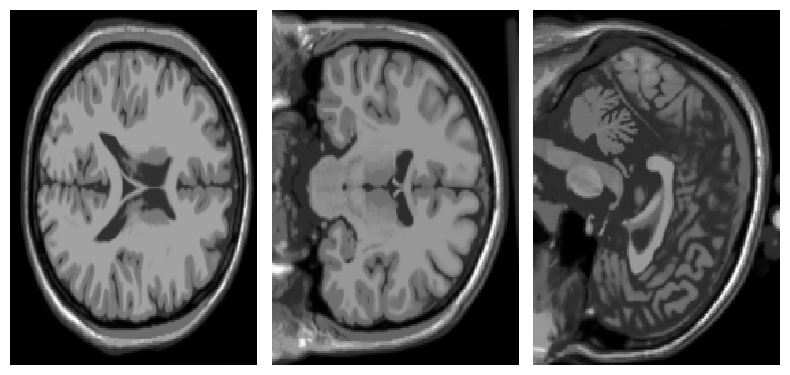

In [13]:
# Load image
pth = "../data/t1_icbm_normal_1mm_pn0_rf0.nii.gz"
nii_y = io.map(pth)
y = nii_y.fdata()

# Visualise
figsize = (8, 4)
fig = show_slices(y, figsize=figsize)

dim_y=tensor([181., 217., 181.], dtype=torch.float64)
dim_x=tensor([181., 217.,  45.], dtype=torch.float64)


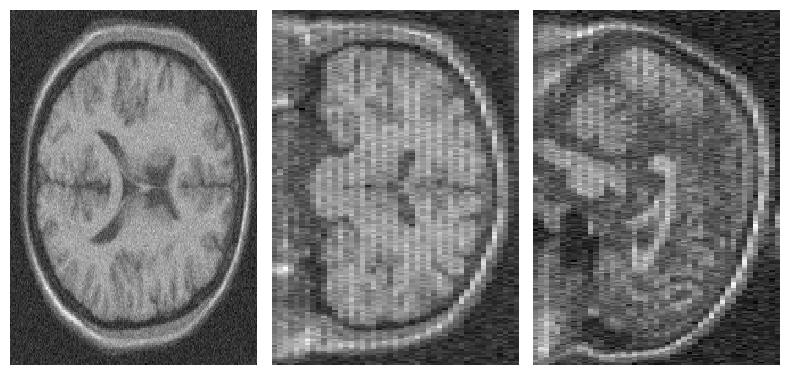

In [14]:
# Apply UniRes forward model to BrainWeb MRI (y = Ax + n)

# Parameters
# https://github.com/brudfors/UniRes/blob/master/unires/struct.py#L57
vx_scl = torch.tensor((1, 1, 4))  # scaling of the voxel sizes to create the low-res image
prof_ip = 0  # (0=rect|1=tri|2=gauss)
prof_tp = 0  # (0=rect|1=tri|2=gauss)
s_gap = 0.0  # slice gap
device = "cuda"  # GPU or CPU
eo_scl = 0.1  # even/odd slice scaling
rigid = torch.eye(4)  # rigid transformation
std_noise = 75 # std of Gaussian noise

# Set output field of view
mat_y = nii_y.affine
dim_y = torch.as_tensor(y.shape, dtype=mat_y.dtype)
scl = torch.as_tensor(torch.cat((vx_scl, torch.ones(1))), dtype=mat_y.dtype)
mat_scl = torch.diag(scl)
mat_x = mat_y.mm(mat_scl)
dim_x = mat_scl[:3, :3].inverse().mm(dim_y[:, None]).floor().squeeze()
print(f"dim_y={dim_y}")
print(f"dim_x={dim_x}")

# Set device
mat_x = mat_x.to(device)
mat_y = mat_y.to(device)
dim_y = dim_y.to(device)
dim_x = dim_x.to(device)
y = y.to(device)

# Create projection operator
po = _proj_info(
    dim_y, mat_y, dim_x, mat_x, 
    rigid=rigid, prof_ip=prof_ip, prof_tp=prof_tp, 
    gap=s_gap, device=device, scl=eo_scl
)
A = lambda y: _proj_apply("A", y[None, None, ...], po)[0, 0, ...]
n = std_noise*torch.randn(dim_x.cpu().type(torch.int).tolist(), device=device)

# Apply forward model A
x = A(y) + n

# Visualise results
fig = show_slices(x, figsize=figsize)

In [15]:
# Run UniRes with super-resolution

# Set input data
data = [[x, mat_x]]

# Settings
s = settings()
s.write_out = False
s.pow = dim_y.cpu().type(torch.int).tolist()
# Run algorithm
y_hat, y_mat, y_pth = preproc(data, sett=s)
y_hat = y_hat[..., 0]


  _   _       _ ____           
 | | | |_ __ (_)  _ \ ___  ___ 
 | | | | '_ \| | |_) / _ \/ __|
 | |_| | | | | |  _ <  __/\__ \
  \___/|_| |_|_|_| \_\___||___/

17/07/2025 18:55:37 | GPU: NVIDIA RTX A3000 Laptop GPU, CUDA: True, PyTorch: 2.6.0+cu126

Input
c=0, n=0 | fname=None

Estimating model hyper-parameters... completed in 0.97690 seconds:
c=0 | tau= 0.0004219 | sd=     48.68 | mu=     406.5 | ct=False 

Mean space | dim=(181, 217, 181), vx=(1.0, 1.0, 1.0)

ADMM step-size=2.0871 | Regularisation scaling=tensor([4.])

Starting super-resolution (update_rigid=False, update_scaling=False) 
 | C=1 | N=1 | device=cuda | max_iter=512 | tol=0.0001 | sched_num=0
  0 - Convergence ( 0.9 s)  | nlyx =  5.478e+06, nlxy =  2.757e+06, nly =  2.721e+06, gain =        inf
  1 - Convergence ( 0.9 s)  | nlyx =  5.258e+06, nlxy =  3.177e+06, nly =  2.081e+06, gain =  1.0000000
  2 - Convergence ( 0.9 s)  | nlyx =  5.001e+06, nlxy =  2.695e+06, nly =  2.306e+06, gain =  0.5381869
  3 - Convergence ( 

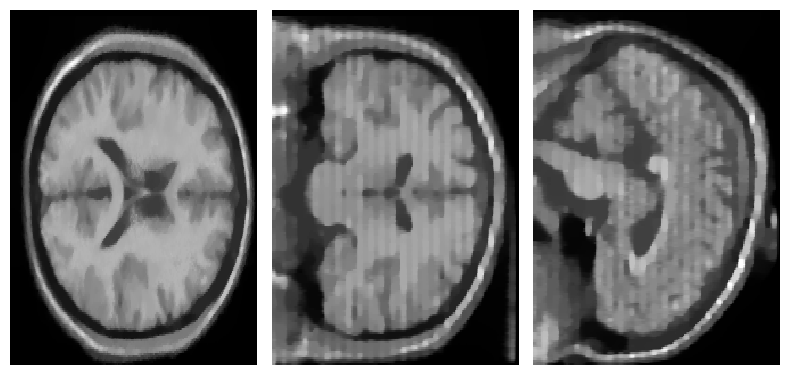

In [16]:
# Visualise results
fig = show_slices(y_hat, figsize=figsize)

In [17]:
# Compute MSE super resolved
print(f"MSE(y, y_hat)={mse(y, y_hat)}")

MSE(y, y_hat)=29327.5078125


In [18]:
# Run UniRes with trilinear reslice

# Settings
s = settings()
s.write_out = False
s.max_iter = 0  # setting the number of iterations to zero makes UniRes use trilinear reslice (instead of super-res)
s.pow = dim_y.cpu().type(torch.int).tolist()
# Run algorithm
y_hat, y_mat, y_pth = preproc(data, sett=s)
y_hat = y_hat[..., 0]


  _   _       _ ____           
 | | | |_ __ (_)  _ \ ___  ___ 
 | | | | '_ \| | |_) / _ \/ __|
 | |_| | | | | |  _ <  __/\__ \
  \___/|_| |_|_|_| \_\___||___/

17/07/2025 18:56:48 | GPU: NVIDIA RTX A3000 Laptop GPU, CUDA: True, PyTorch: 2.6.0+cu126

Input
c=0, n=0 | fname=None



Mean space | dim=(181, 217, 181), vx=(1.0, 1.0, 1.0)


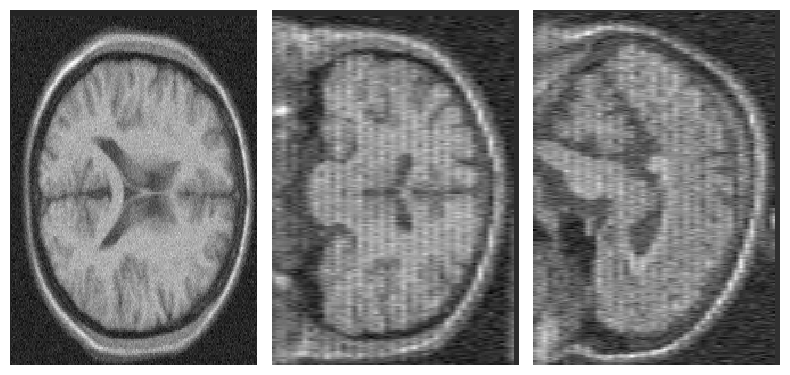

In [19]:
# Visualise results
fig = show_slices(y_hat, figsize=figsize)

In [20]:
# Compute MSE trilinear
print(f"MSE(y, y_hat)={mse(y, y_hat)}")

MSE(y, y_hat)=35222.9921875
